In this Notebook, LSTM is applied to correlate/ predict whether the pump may be shut down (broken) for a period of time based on the input signal of the sensors.

The input parameters of the model used are the sensor parameters (in the database called sensors from 00 to 51). The output of the model is a single parameter: the pump operating state corresponding to 0 is the shutdown state, 1 is the normal operation state and 0.5 is recovering.

This Notebook will analyze the correlation between the input parameters (sensors) and determine which parameters are the most important, deciding on the output of the model, thereby building the simplest model, which requires less input parameters but the most accurate prediction results.

In [ ]:
import numpy as np
import pandas as pd

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
from google.colab import drive

drive.mount('/content/drive')
!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nphantawee/pump-sensor-data


Mounted at /content/drive
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 kB 19.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for lxml
ERROR: Could not build wheels for lxml, which is required to install pyproject.toml-based p

In [4]:
!unzip pump-sensor-data.zip

Archive:  pump-sensor-data.zip
  inflating: sensor.csv              


In [5]:
import pandas as pd
data =  pd.read_csv("/content/sensor.csv")

In [6]:
data.shape

(220320, 55)

In [7]:
data.columns

Index(['Unnamed: 0', 'timestamp', 'sensor_00', 'sensor_01', 'sensor_02',
       'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07',
       'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12',
       'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17',
       'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22',
       'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27',
       'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32',
       'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37',
       'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42',
       'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47',
       'sensor_48', 'sensor_49', 'sensor_50', 'sensor_51', 'machine_status'],
      dtype='object')

In [8]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,220320.0,110159.500000,63601.049991,0.000000,55079.750000,110159.500000,165239.250000,220319.000000
sensor_00,210112.0,2.372221,0.412227,0.000000,2.438831,2.456539,2.499826,2.549016
sensor_01,219951.0,47.591611,3.296666,0.000000,46.310760,48.133678,49.479160,56.727430
sensor_02,220301.0,50.867392,3.666820,33.159720,50.390620,51.649300,52.777770,56.032990
sensor_03,220301.0,43.752481,2.418887,31.640620,42.838539,44.227428,45.312500,48.220490
sensor_04,220301.0,590.673936,144.023912,2.798032,626.620400,632.638916,637.615723,800.000000
sensor_05,220301.0,73.396414,17.298247,0.000000,69.976260,75.576790,80.912150,99.999880
sensor_06,215522.0,13.501537,2.163736,0.014468,13.346350,13.642940,14.539930,22.251160
sensor_07,214869.0,15.843152,2.201155,0.000000,15.907120,16.167530,16.427950,23.596640
sensor_08,215213.0,15.200721,2.037390,0.028935,15.183740,15.494790,15.697340,24.348960


In [9]:
data.isnull().sum()

Unnamed: 0             0
timestamp              0
sensor_00          10208
sensor_01            369
sensor_02             19
sensor_03             19
sensor_04             19
sensor_05             19
sensor_06           4798
sensor_07           5451
sensor_08           5107
sensor_09           4595
sensor_10             19
sensor_11             19
sensor_12             19
sensor_13             19
sensor_14             21
sensor_15         220320
sensor_16             31
sensor_17             46
sensor_18             46
sensor_19             16
sensor_20             16
sensor_21             16
sensor_22             41
sensor_23             16
sensor_24             16
sensor_25             36
sensor_26             20
sensor_27             16
sensor_28             16
sensor_29             72
sensor_30            261
sensor_31             16
sensor_32             68
sensor_33             16
sensor_34             16
sensor_35             16
sensor_36             16
sensor_37             16


In [10]:
data.drop(['Unnamed: 0', 'timestamp','sensor_00','sensor_15','sensor_50','sensor_51'],axis=1, inplace=True)

We need to note that, because sensors are not specifically noted what operating parameters, for example, pressure, temperature, flow, vibration, ... they measure. However, concretely and quickly making a judgment about which sensor will be the decisive parameter to the operating status and operation of the pump is very important.

In actual operation, pump systems are often equipped with more than one sensor for a single operating parameter, such as pressure, flow rate or temperature, for a variety of reasons such as safety, operation or system reliability or automation equipment confidence. This can be the cause of the overlap in the measured signals of some sensors as analyzed following.

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

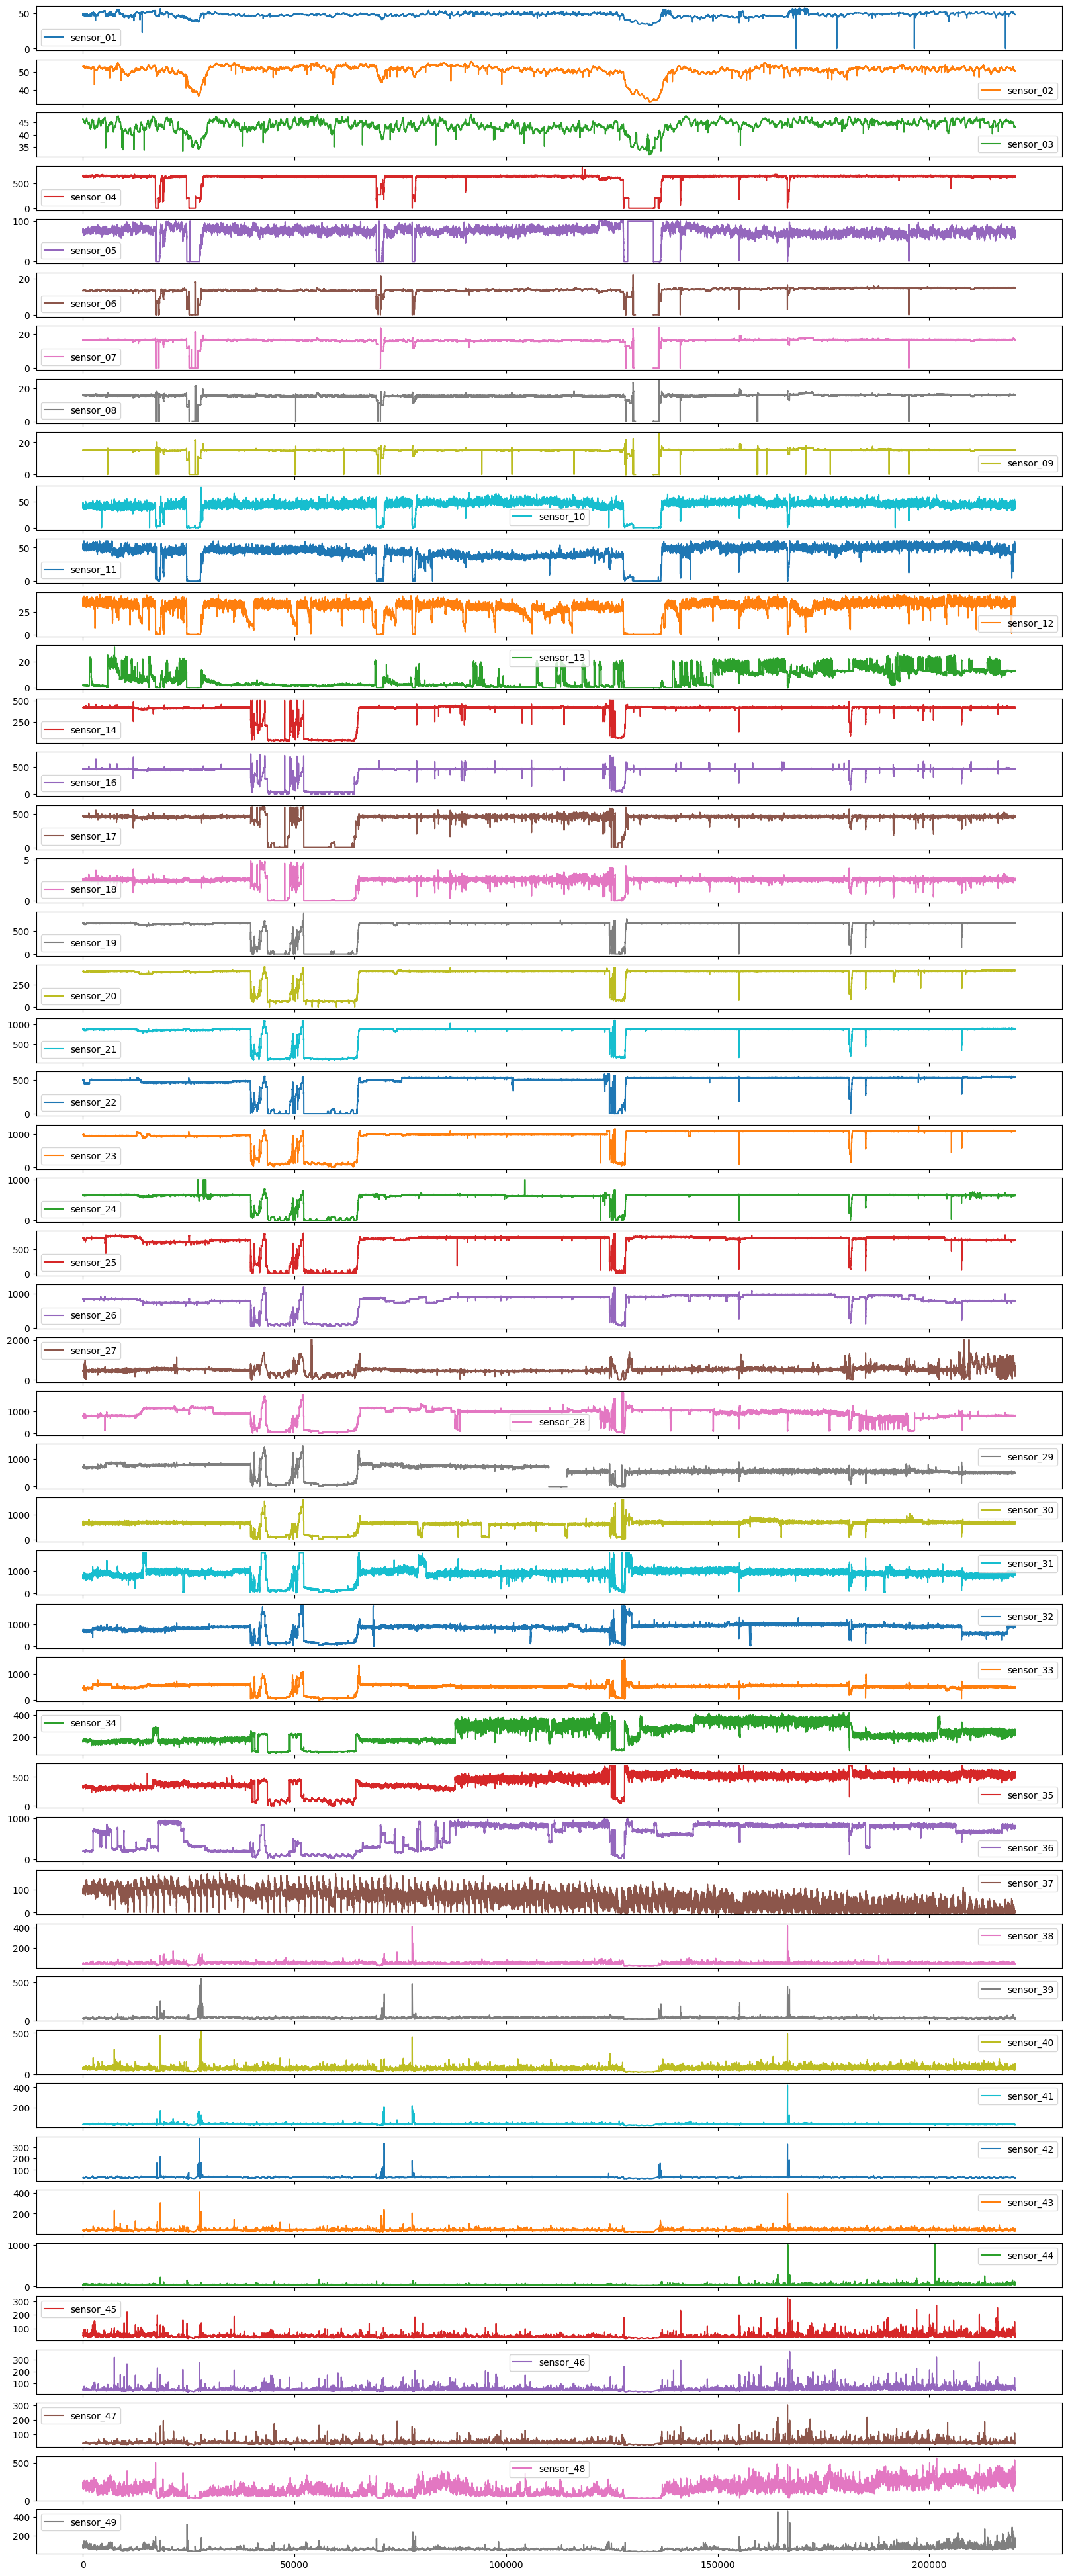

In [11]:
import matplotlib.pyplot as plt
data.plot(subplots =True, sharex = True, figsize = (20,50))

As can be seen there are a pattern being captured by the sensors, example:
• (1,2,3),
• (4,5,6,7,8,9),
• (10,11,12),
• (14,16,17,18),
• (19,20,21,22,23,24),
• (25,26,28,29,30,31,32,33),
• (34,35),
• (38,39,40,41,42,43,45,46,47).

In turn, there are signals that are very noisy and seem to follow no trend in particular.

On the basis of that analysis, determining which sensor signal influence the operating state of the pump is important for modeling. To optimize the model, we proceed to select the input parameters of the model according to the following hypotheses.

In [12]:
data['machine_status'].value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

The database has 7 BROKEN states, which are then RECOVERED and returned to a NORMAL operating state. For the sack of simplicity, we can assume that 25% of the data could be used to train the model (covering 2 BROKEN states), the remaining 75% of the data is used to test the predictability of the model based on input parameters (covers 5 BROKEN points).

For graphical illustration purpose, we assume the BROKEN state transitions have a value of 0, the RECOVERING state and NORMAL operation value 0.5 and 1, respectively and converted it into a new column named: "Operation".

In [13]:
import numpy as np
conditions = [(data['machine_status'] =='NORMAL'), (data['machine_status'] =='BROKEN'), (data['machine_status'] =='RECOVERING')]
choices = [1, 0, 0.5]
data['Operation'] = np.select(conditions, choices, default=0)

In order to check if there is some obvious patterns that could be landmarked in a certain period, we have added the "Operation" code in the illustrations. That could helps us to define a good dataset to fit the model.

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

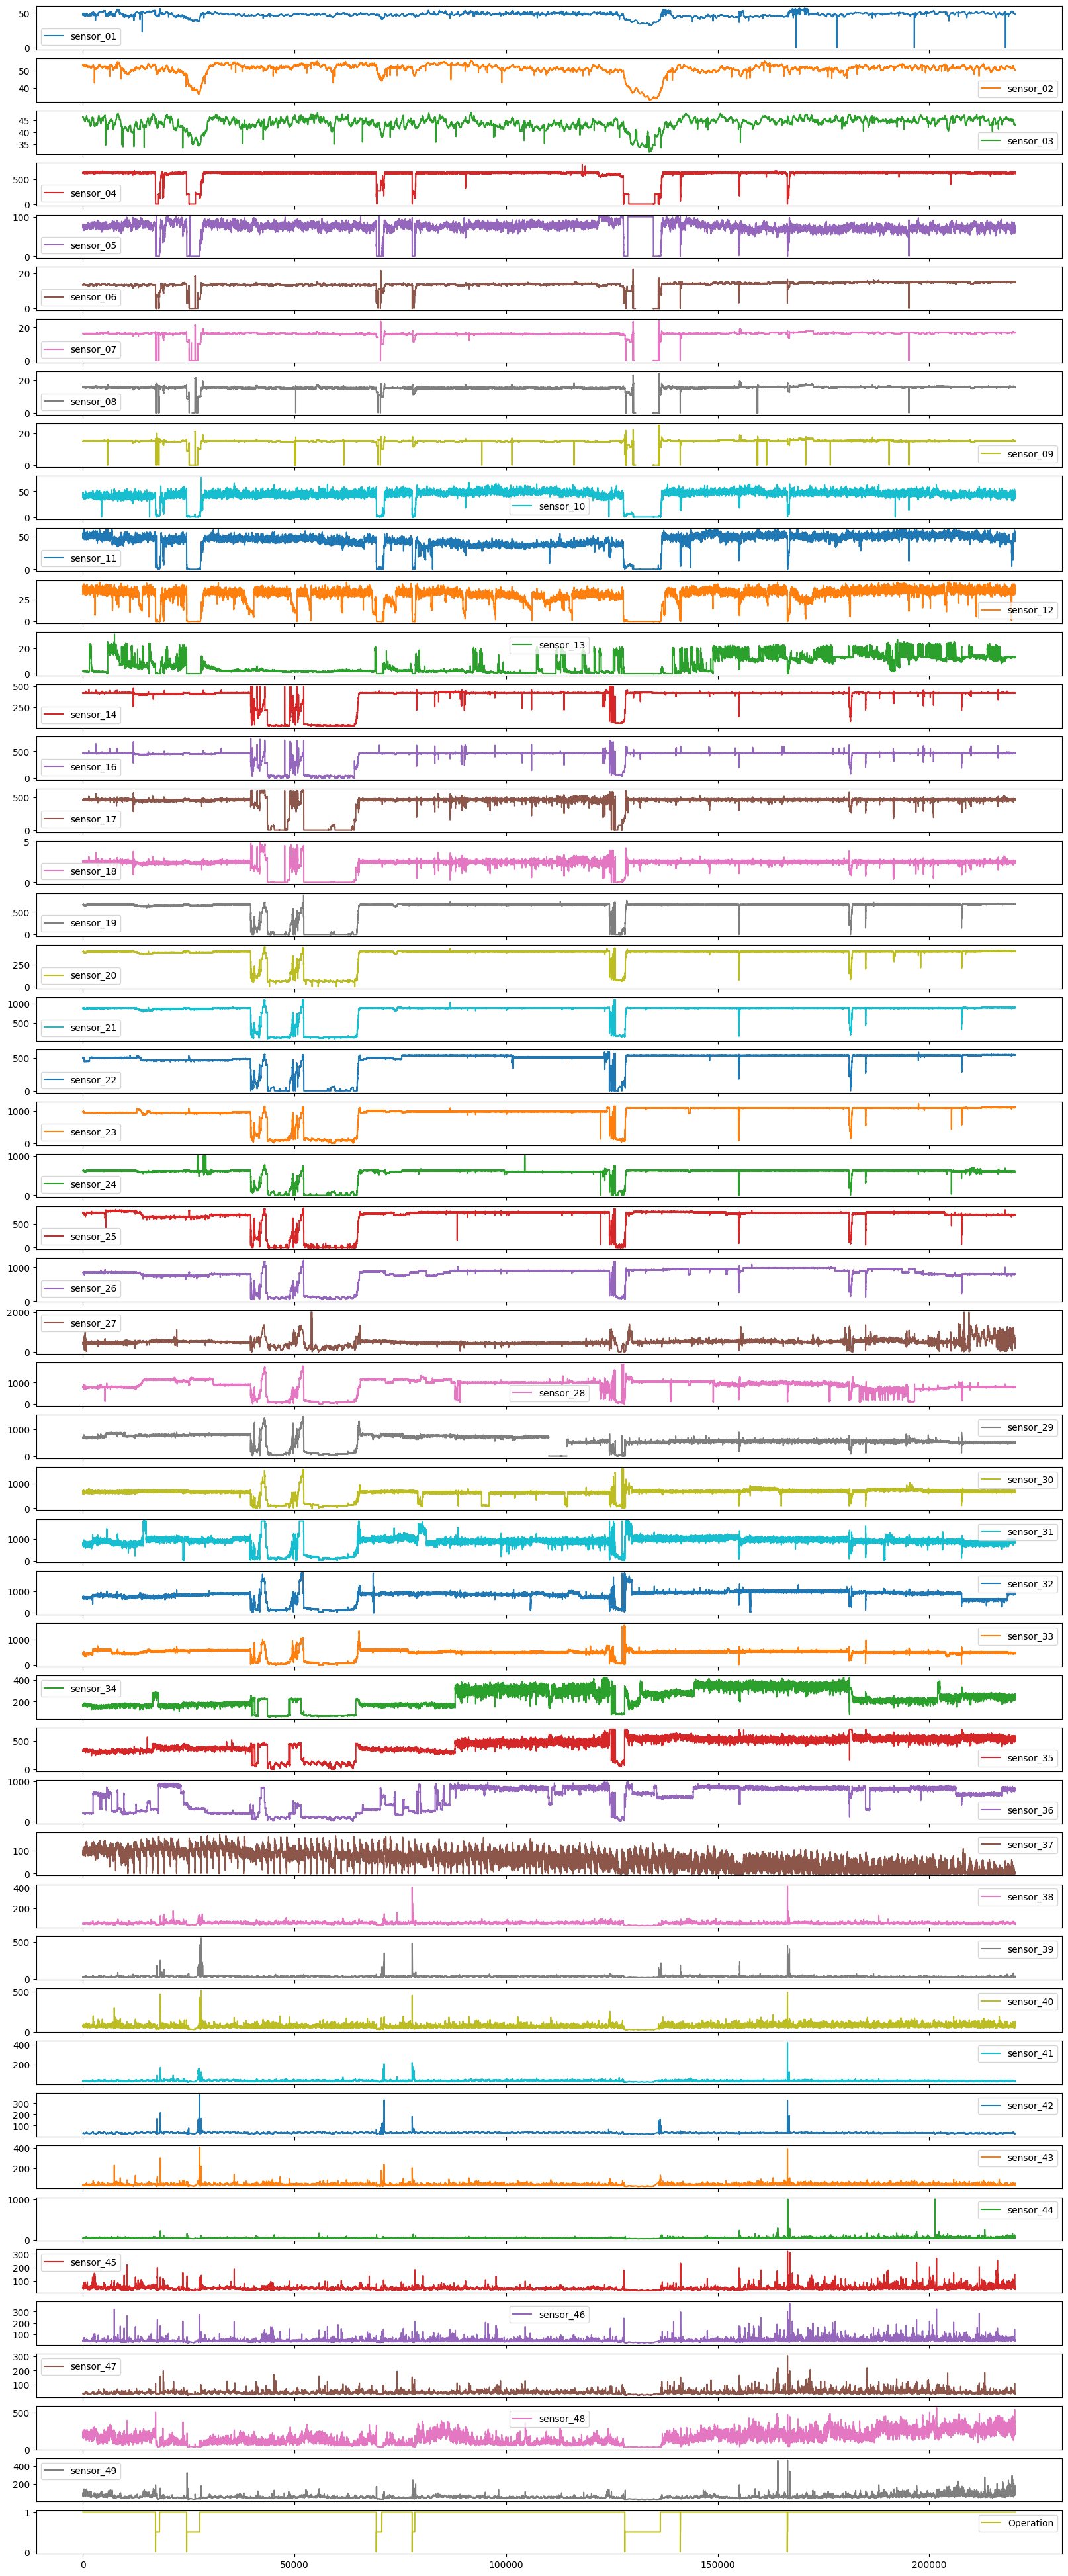

In [14]:
import matplotlib.pyplot as plt
data.plot(subplots =True, sharex = True, figsize = (20,50))

In [15]:
data.columns

Index(['sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05',
       'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_16',
       'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21',
       'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26',
       'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31',
       'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36',
       'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41',
       'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46',
       'sensor_47', 'sensor_48', 'sensor_49', 'machine_status', 'Operation'],
      dtype='object')

As analyzed above, many measurements follow the same trend. To this end, one starts by keeping only the features of interest and drop the rest. Then, one performes feature normalization to bring all values into the range [0,1]. Starting by dropping unused features, one can proceed as follows.

In [16]:
df0 = pd.DataFrame(data, columns=['Operation','sensor_04', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09'])

In [17]:
df1 = pd.DataFrame(data, columns=['Operation','sensor_01', 'sensor_04', 'sensor_10', 'sensor_14', 'sensor_19', 'sensor_25'])

In [18]:
df2 = pd.DataFrame(data, columns = ['Operation','sensor_02', 'sensor_05', 'sensor_11', 'sensor_16', 'sensor_20', 'sensor_26'])

In [19]:
df3 = pd.DataFrame(data, columns = ['Operation','sensor_03', 'sensor_06', 'sensor_12', 'sensor_17', 'sensor_21', 'sensor_28'])

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

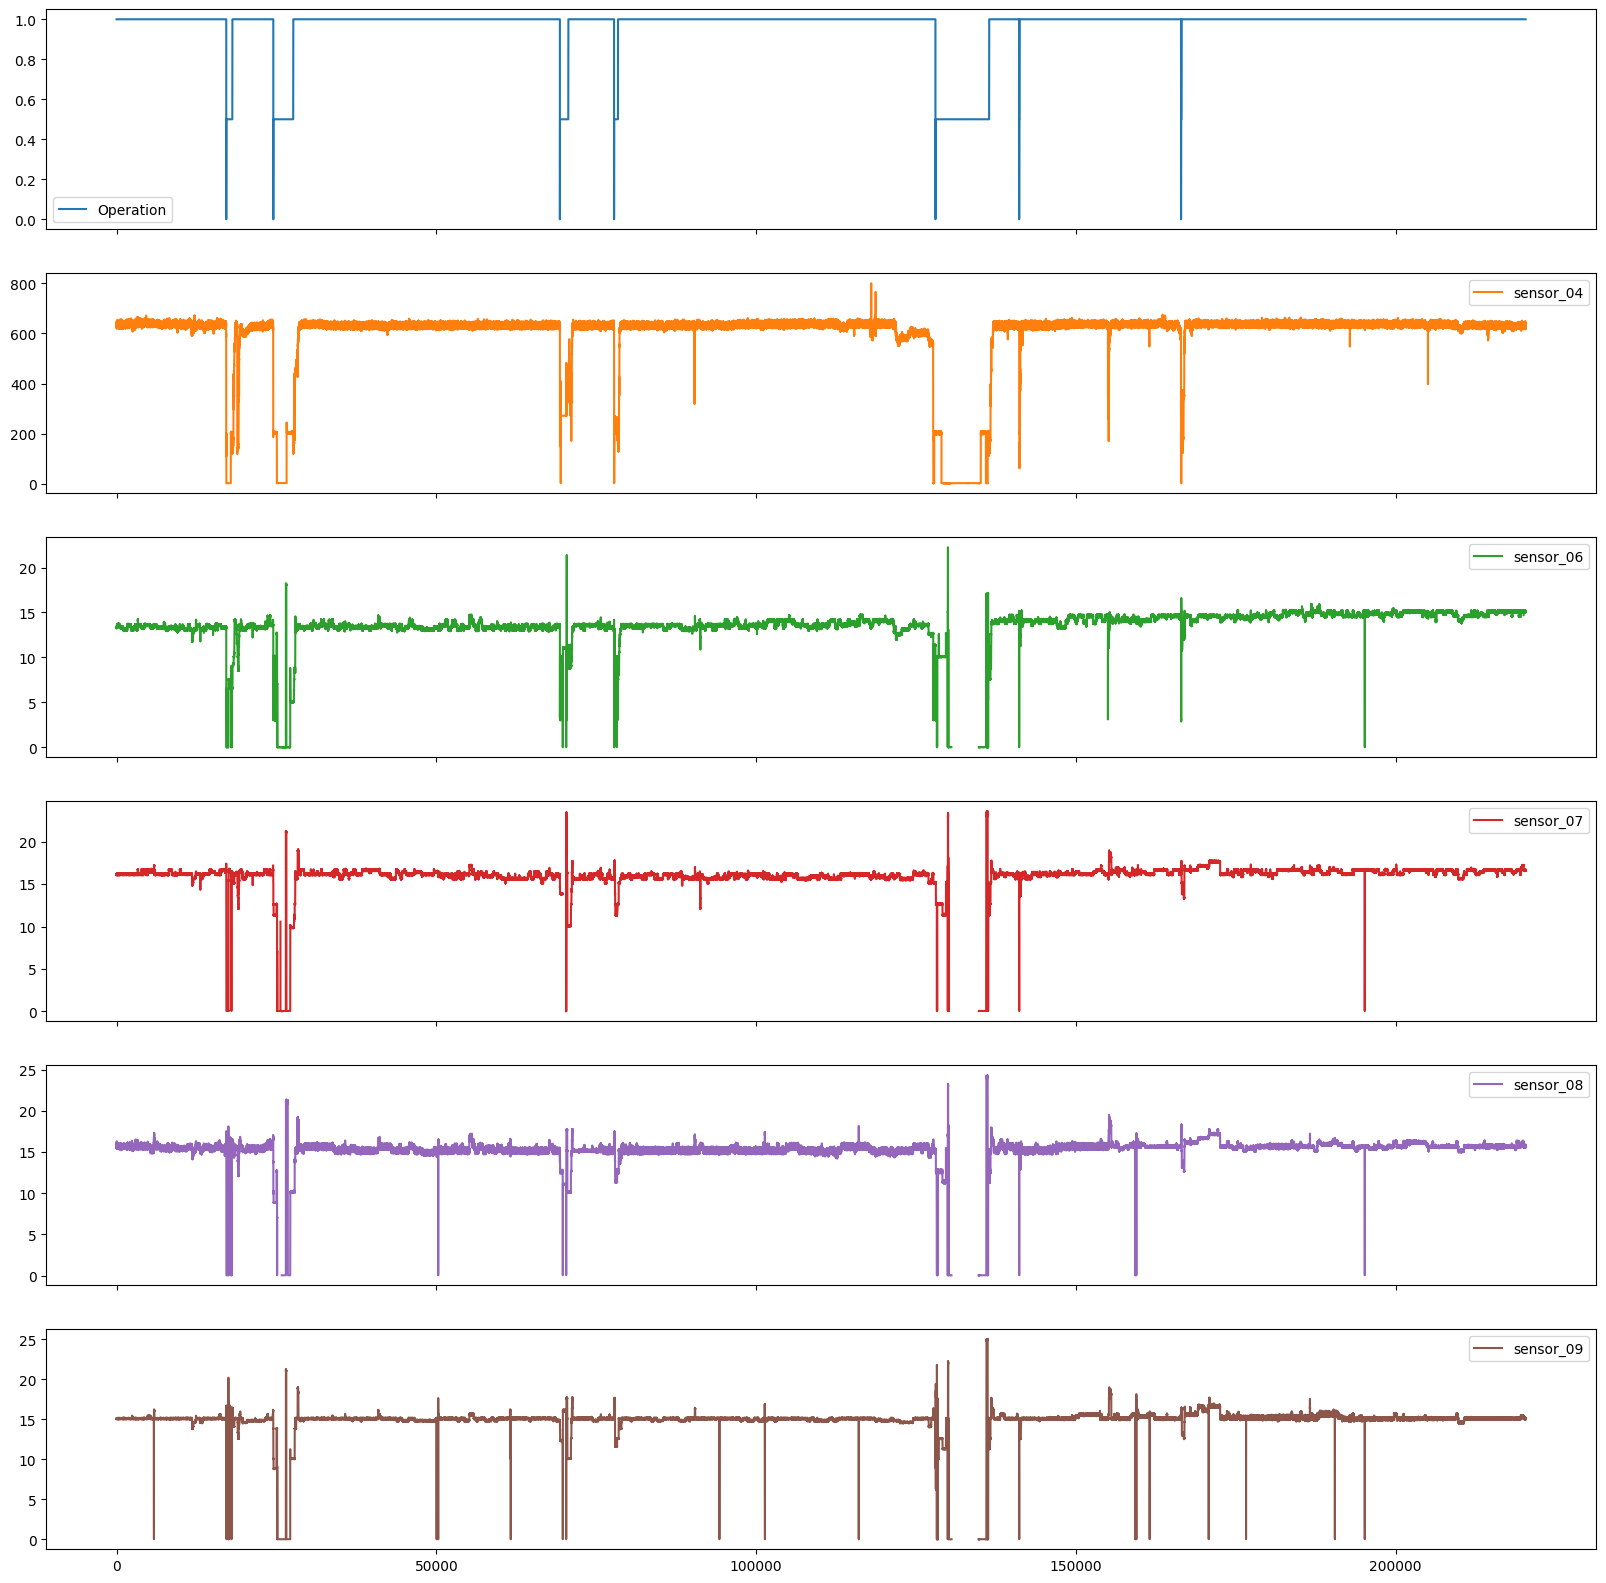

In [20]:
df0.plot(subplots =True, sharex = True, figsize = (20,20))

It seems that this time data series correlate a lot with the failure of the machine and can be a good indicator of the failure of the system, we will check it for another dataset. For now, the only concern is manipulation and prediction to test the robustness of classical methods.

In [21]:
df = df0
df.shape

(220320, 6)

In [22]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [23]:
from sklearn.preprocessing import MinMaxScaler

values = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df.shape[1]+1, 2*df.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data spliting into train and test data series.
values = reframed.values
n_train_time = 50000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

Epoch 1/50
4167/4167 - 33s - loss: 0.0070 - val_loss: 0.0021 - 33s/epoch - 8ms/step
Epoch 2/50
4167/4167 - 28s - loss: 0.0019 - val_loss: 0.0043 - 28s/epoch - 7ms/step
Epoch 3/50
4167/4167 - 30s - loss: 0.0030 - val_loss: 0.0056 - 30s/epoch - 7ms/step
Epoch 4/50
4167/4167 - 31s - loss: 0.0028 - val_loss: 0.0059 - 31s/epoch - 7ms/step
Epoch 5/50
4167/4167 - 32s - loss: 0.0027 - val_loss: 0.0063 - 32s/epoch - 8ms/step
Epoch 6/50
4167/4167 - 33s - loss: 0.0028 - val_loss: 0.0072 - 33s/epoch - 8ms/step
Epoch 7/50
4167/4167 - 28s - loss: 0.0027 - val_loss: 0.0066 - 28s/epoch - 7ms/step
Epoch 8/50
4167/4167 - 29s - loss: 0.0024 - val_loss: 0.0058 - 29s/epoch - 7ms/step
Epoch 9/50
4167/4167 - 30s - loss: 0.0020 - val_loss: 0.0050 - 30s/epoch - 7ms/step
Epoch 10/50
4167/4167 - 31s - loss: 0.0016 - val_loss: 0.0044 - 31s/epoch - 7ms/step
Epoch 11/50
4167/4167 - 31s - loss: 0.0013 - val_loss: 0.0037 - 31s/epoch - 7ms/step
Epoch 12/50
4167/4167 - 29s - loss: 0.0010 - val_loss: 0.0029 - 29s/epoch 

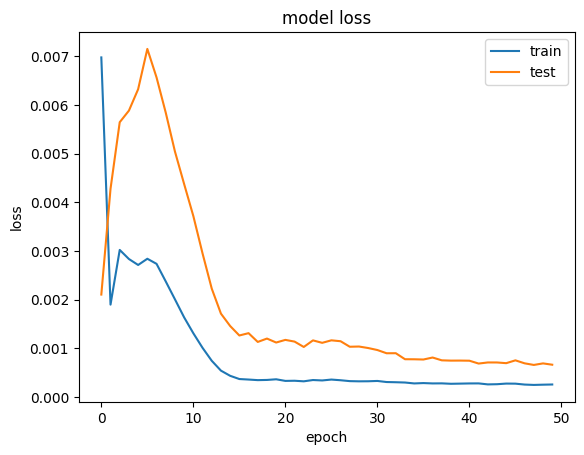

5133/5133 [==============================] - 8s 2ms/step
Test RMSE: 0.026


In [24]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model.fit(train_x, train_y, epochs=50, batch_size=12, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df.shape[1]

# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

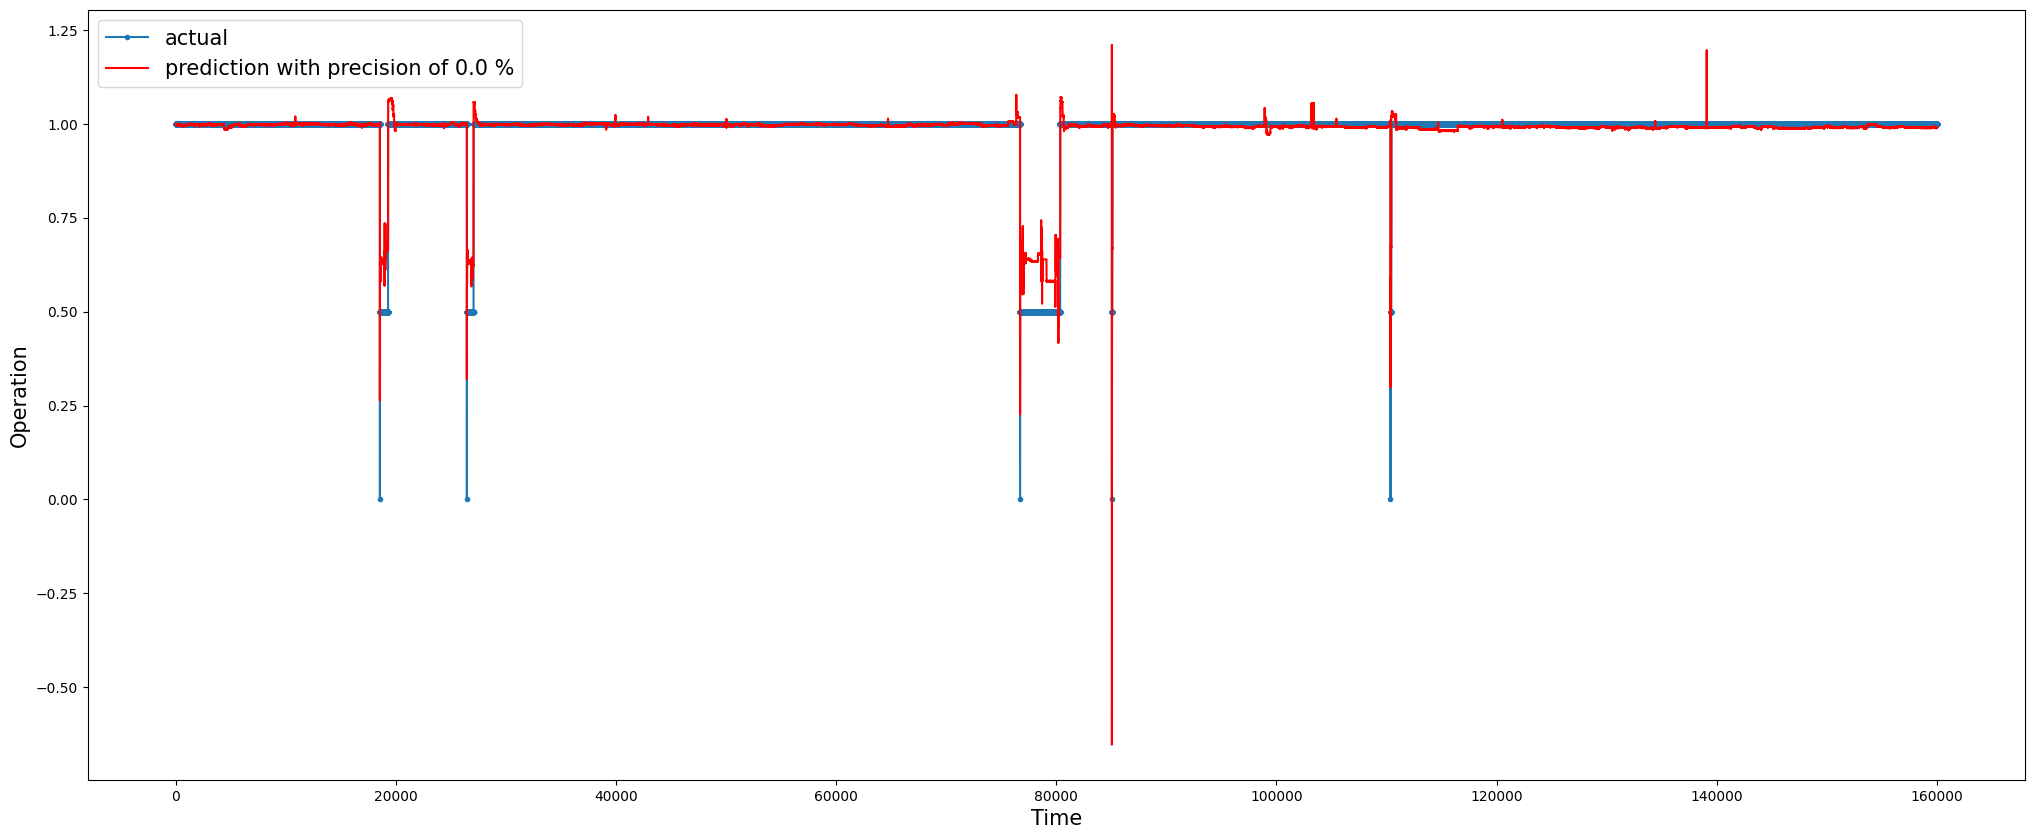

In [25]:
import numpy as np
e = np.round(sum(np.abs(inv_y[:]-inv_yhat[:]))/(sum(inv_y[:])*len(inv_y[:]))*100,2)
aa=[x for x in range(160000)]
plt.figure(figsize=(25,10))
plt.plot(aa, inv_y[:160000], marker='.', label="actual")
plt.plot(aa, inv_yhat[:160000], 'r', label="prediction with precision of {} %".format(e))
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time', size=15)
plt.legend(fontsize=15)
plt.show()

In [26]:
df = df2
df.shape

(220320, 7)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

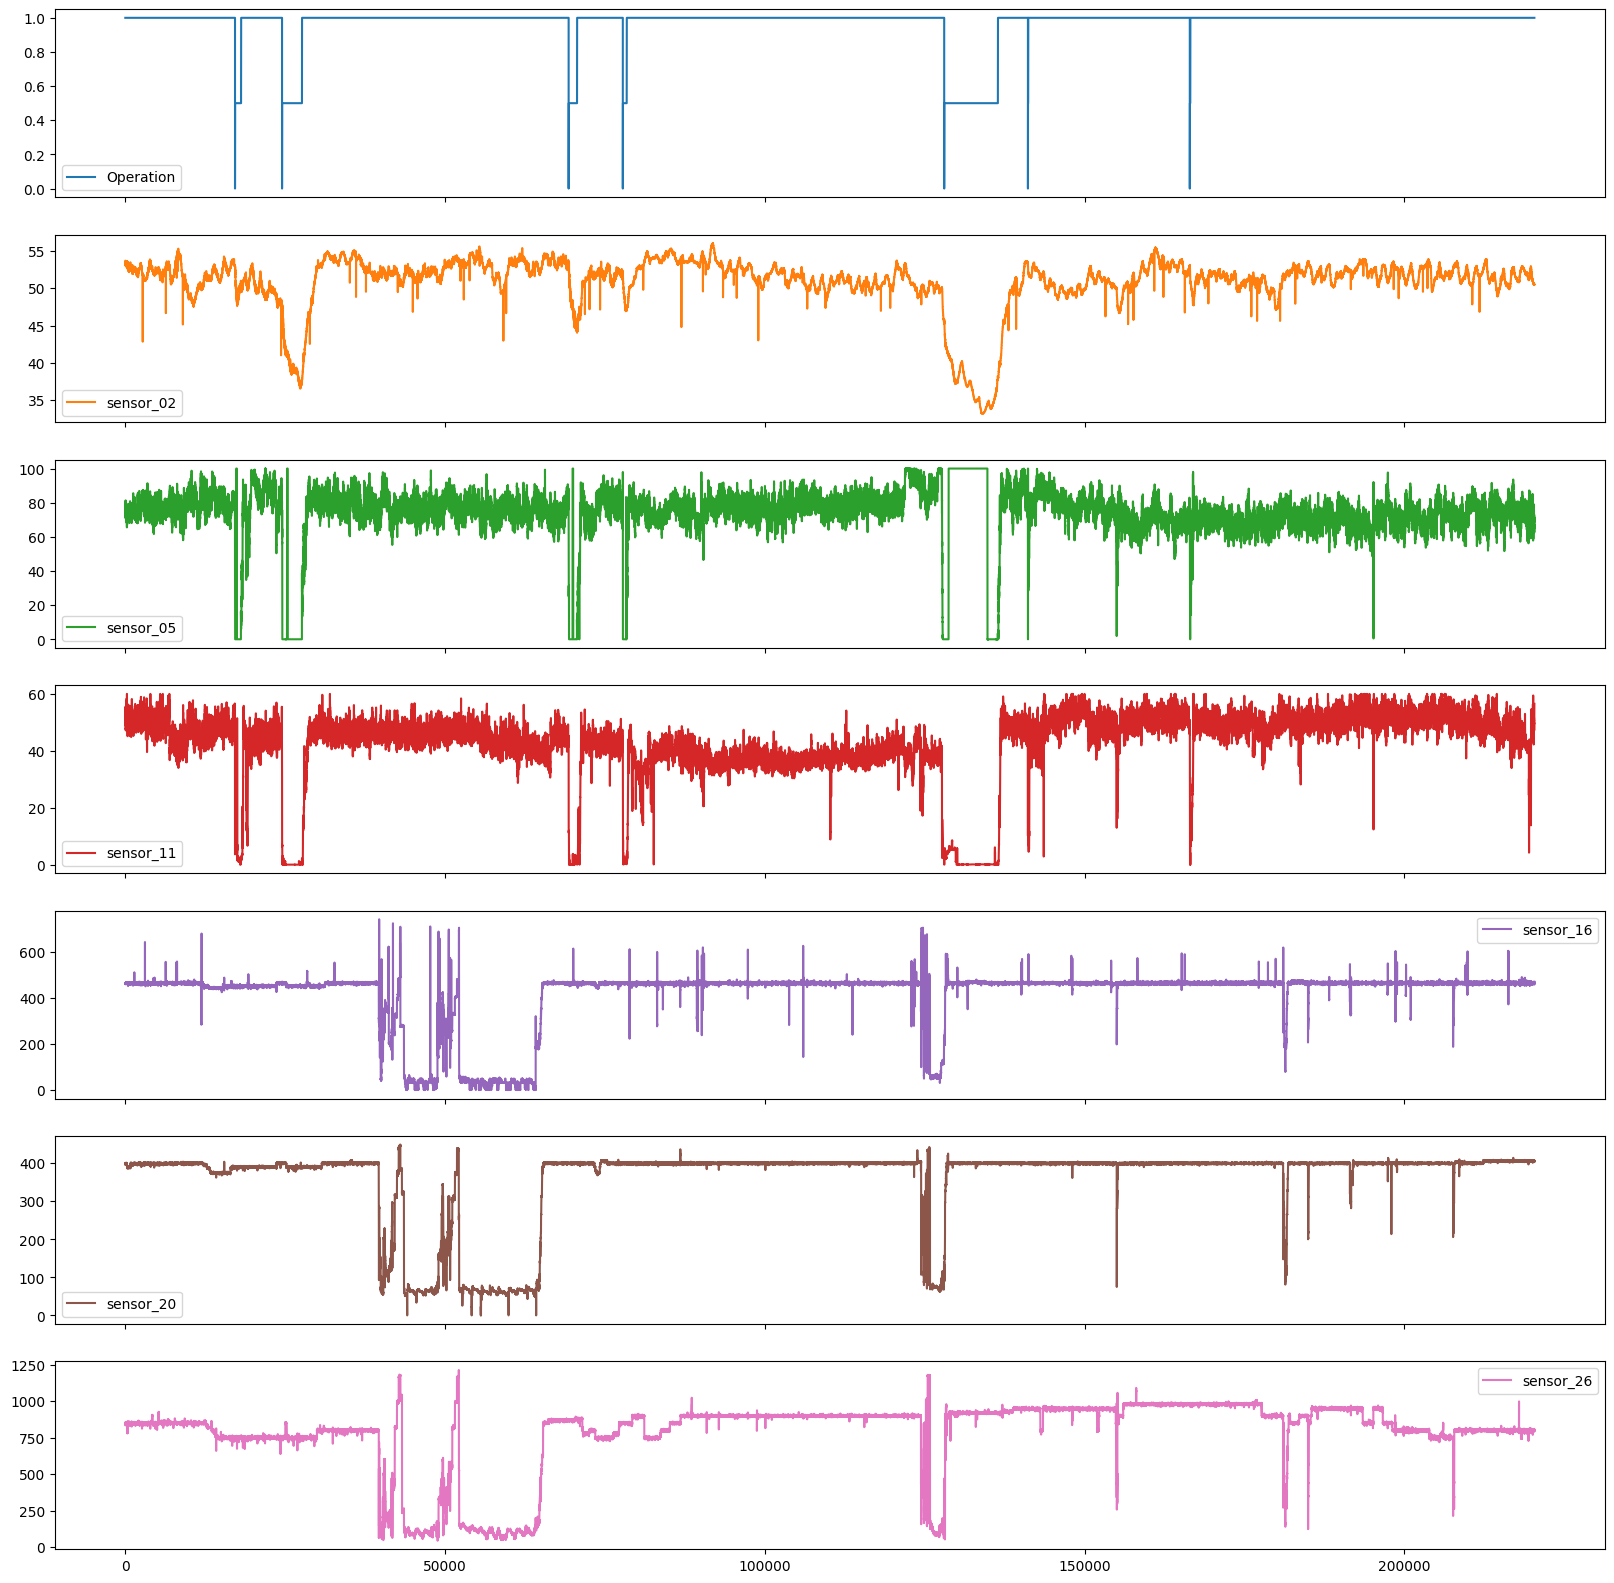

In [27]:
df2.plot(subplots =True, sharex = True, figsize = (20,20))

In [28]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [29]:
from sklearn.preprocessing import MinMaxScaler

values = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df.shape[1]+1, 2*df.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data spliting into train and test data series.
values = reframed.values
n_train_time = 50000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

Epoch 1/150
715/715 - 10s - loss: 0.0295 - val_loss: 0.0114 - 10s/epoch - 13ms/step
Epoch 2/150
715/715 - 8s - loss: 0.0071 - val_loss: 0.0072 - 8s/epoch - 11ms/step
Epoch 3/150
715/715 - 7s - loss: 0.0062 - val_loss: 0.0056 - 7s/epoch - 9ms/step
Epoch 4/150
715/715 - 8s - loss: 0.0057 - val_loss: 0.0051 - 8s/epoch - 11ms/step
Epoch 5/150
715/715 - 7s - loss: 0.0053 - val_loss: 0.0054 - 7s/epoch - 10ms/step
Epoch 6/150
715/715 - 7s - loss: 0.0050 - val_loss: 0.0059 - 7s/epoch - 10ms/step
Epoch 7/150
715/715 - 7s - loss: 0.0048 - val_loss: 0.0064 - 7s/epoch - 10ms/step
Epoch 8/150
715/715 - 6s - loss: 0.0044 - val_loss: 0.0069 - 6s/epoch - 8ms/step
Epoch 9/150
715/715 - 7s - loss: 0.0040 - val_loss: 0.0075 - 7s/epoch - 10ms/step
Epoch 10/150
715/715 - 8s - loss: 0.0037 - val_loss: 0.0078 - 8s/epoch - 11ms/step
Epoch 11/150
715/715 - 7s - loss: 0.0033 - val_loss: 0.0082 - 7s/epoch - 10ms/step
Epoch 12/150
715/715 - 8s - loss: 0.0030 - val_loss: 0.0082 - 8s/epoch - 11ms/step
Epoch 13/150


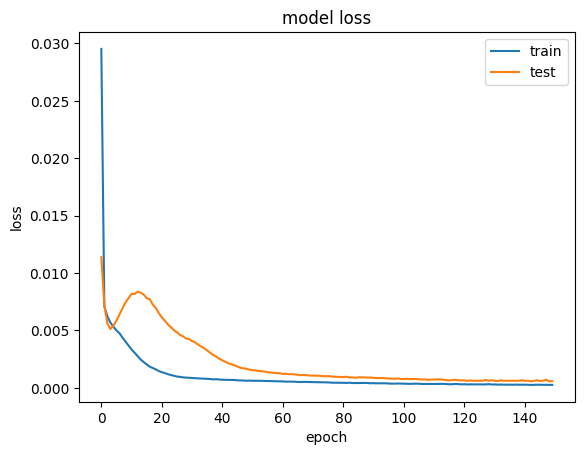

5321/5321 [==============================] - 9s 2ms/step
Test RMSE: 0.024


In [30]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model.fit(train_x, train_y, epochs=150, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df.shape[1]

# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

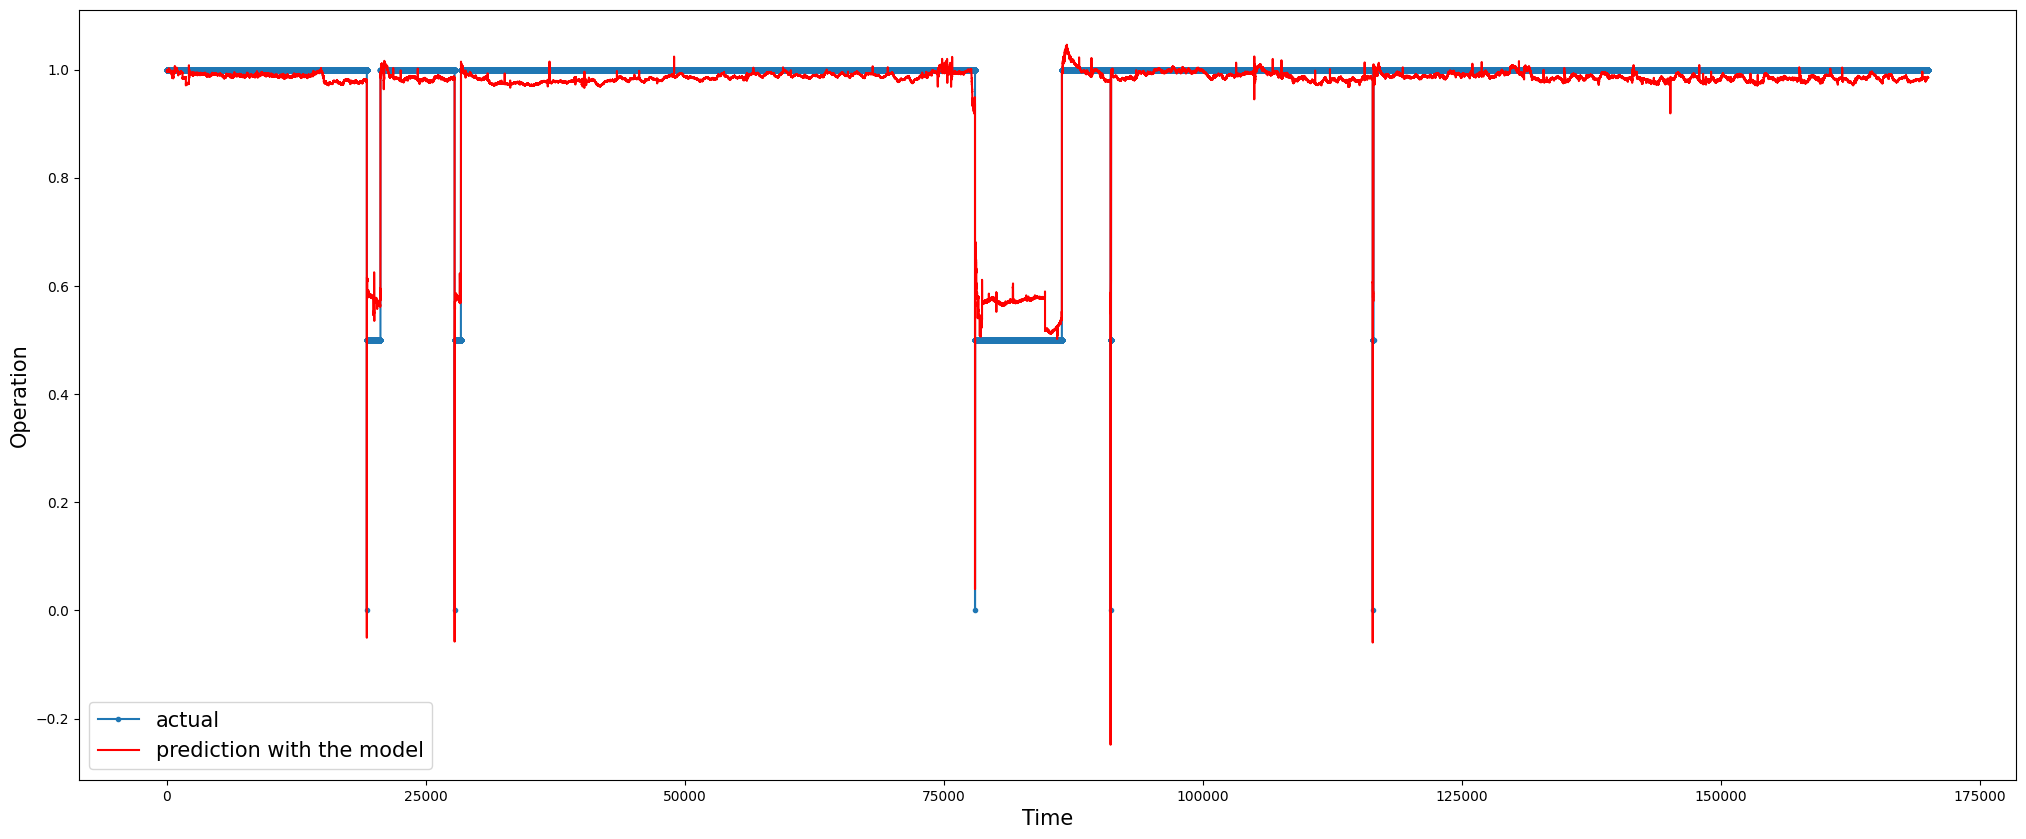

In [31]:
import numpy as np
aa=[x for x in range(170000)]
plt.figure(figsize=(25,10))
plt.plot(aa, inv_y[:170000], marker='.', label="actual")
plt.plot(aa, inv_yhat[:170000], 'r', label="prediction with the model")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time', size=15)
plt.legend(fontsize=15)
plt.show()